# TR-Santé : Observe bacteria interaction to define the relations

**Introduction :** The main goal of this project is to determine the relations between bacteria. 
Indeed, there are two main processes for bacteria to exchange biological information through DNA :

- **HGT : Horizontal Gene Transfer**

This process has been studied already (*cf bibliography*), in general it concerns transfer of genes situated far away.
- **HAT : Horizontal Allele Transfer**

This process is also called 'recombination', it concerns in general genes that are situated at the same place between bacteria.

## First step : Comparing two genomes of bacteria

In [1]:
# Import the necessary modules
import os
from subprocess import call
import re
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import math
import bisect

### Using Mummer

We will first use mummer to compare the genomes of two bacteria.
Here the code is very simple, we only use the 'mum' attribute, which is computing the maximal matches that are unique in both sequences.
We then plot a histogram with a log-log scale to interpret the results.

mummer -mum /home/antoine/fasta/NC_020307.1.fasta /home/antoine/fasta/NZ_AP017617.1.fasta


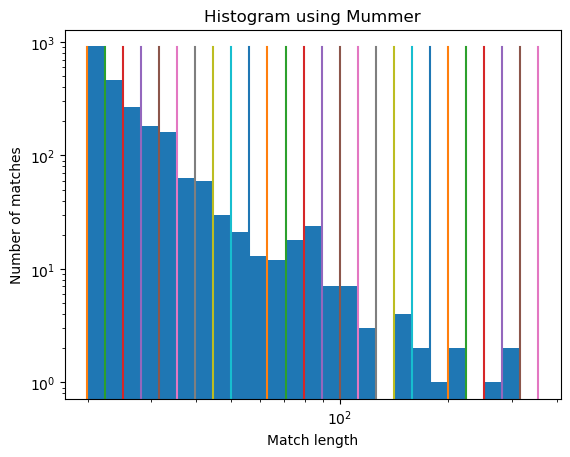

In [38]:
# Set the names of the two bacteria
bacteria1 = "/home/antoine/fasta/NC_020307.1.fasta"
bacteria2 = "/home/antoine/fasta/NZ_AP017617.1.fasta"

# Use mummer to compare the genomes of the two bacteria
print("mummer", "-mum", bacteria1, bacteria2)
#mummer_init = subprocess.run("conda activate bio")
mummer_output = subprocess.run(["mummer", "-mum", bacteria1, bacteria2], capture_output=True, cwd='/')

# Parse the output from mummer to get the list of matches
matches = []
for line in mummer_output.stdout.splitlines():
    if line.startswith(b" "):
        
        # This line contains a match, so get the length of the match
        match_length = int(line.split()[-1])
        matches.append(match_length)

# Plot the graph of the number of matches according to the length of the segments
bins = [10**(i/20) for i in range(26, 52)]
pl.hist(matches, bins=bins)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
for bin in bins[:34]:
    plt.plot([bin,bin], [0, 900])
pl.xlabel("Match length")
pl.ylabel("Number of matches")
plt.title("Histogram using Mummer")
pl.show()

Now we will go further by adding more attributes to the mummer command : 
- First the 'maxmatch' attribute, which will compute all maximal matches regardless of their uniqueness.
- Then the '-b' option to calculate the pairings on the complementary strands.
- Finally the '-n' attribute to exclude nucleotides for which we have no information.

Then we also plot few power-law which should be rightly representing our results because of the theory of gene transfer.

In [3]:
# Set the names of the two bacteria
bacteria1 = "/home/antoine/fasta/NC_020307.1.fasta"
bacteria2 = "/home/antoine/fasta/NZ_AP017617.1.fasta"

# Use mummer to compare the genomes of the two bacteria
print("mummer", "-maxmatch", "-n", "-b", bacteria1, bacteria2)
#mummer_init = subprocess.run("conda activate bio")
mummer_output = subprocess.run(["mummer", "-maxmatch", "-n", "-b", bacteria1, bacteria2], capture_output=True, cwd='/')

# Parse the output from mummer to get the list of matches
max_matches = []
for line in mummer_output.stdout.splitlines():
    if line.startswith(b" "):
        # This line contains a match, so get the length of the match
        match_length = int(line.split()[-1])
        max_matches.append(match_length)


# compute the logarithmically binned histogram of the match lengths
#bins = [10**(i/35) for i in range(46, 105)]  # bins from 10 to 1e4
#hist, _ = np.histogram([m for m in max_matches], bins=bins)
matches_sorted = max_matches.sort()

mummer -maxmatch -n -b /home/antoine/fasta/NC_020307.1.fasta /home/antoine/fasta/NZ_AP017617.1.fasta


### Without logarithmic bining

We can plot first without logarithmic bining, then we will therefore have more points when we will reach long matches. It is a great first plot to see the repartition of matches and to compare to known-models.
To do so, we first create a function named `count_occurences` to know the number of matches associated to each length.

In [4]:
def count_occurrences(numbers):
  # Create a new list to store the results
  results = []

  # Create a variable to store the current number we are counting
  current_number = None

  # Create a variable to store the current number of occurrences
  current_count = 0
  
  # Iterate over the numbers in the list
  for number in numbers:
    # If the current number is different from the number we are counting,
    # add the current number and its count to the results list, and reset
    # the current number and count
    if number != current_number:
      if current_number is not None:
        results.append([current_number, current_count])
      current_number = number
      current_count = 0

    # Increment the current count
    current_count += 1

  # Add the final number and its count to the results list
  results.append([current_number, current_count])

  return results

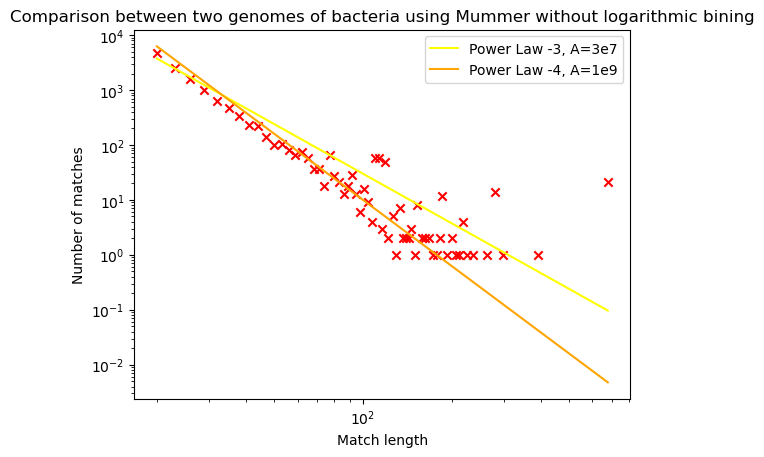

In [5]:
matches_sorted = count_occurrences(max_matches)
segment_lengths, occurrences = zip(*matches_sorted)


# Create the logarithmic bins using numpy
bins = np.logspace(np.log10(min(segment_lengths)), np.log10(max(segment_lengths)), 10)

# Plot the logarithmic bins using matplotlib
#plt.hist(segment_lengths, bins=bins, weights=occurrences)
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**7/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins, Powerlaw_3, color = 'yellow', label = 'Power Law -3, A=3e7')
plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=1e9')
plt.scatter(segment_lengths[::3], occurrences[::3], color = 'r', marker = 'x')
plt.xscale('log')
plt.title('Comparison between two genomes of bacteria using Mummer without logarithmic bining')
plt.yscale('log')
plt.legend()
plt.show()

We have got our first plot of a third of our lengths !
A first interesting point is that it seems that our matches tend to respect the power-law models, even though there are still noise to work on.

### With logarithmic bining

Now we are going to use something called a ``logarithmic bining``. 

The logarithmic bining is a method used in order to represent points in a log-log graph, regrouping them in bins by dividing the number of matches in that bin by the size of the bin. 

Therefore, we reduce the noise that might appears with large matches and we obtain one point for each bin.
We can then try to find bins to rightly tackle our comparison of bacteria.

First we create few functions to find the right bins, to regroup matches and to divide by the length of the bin.

In [6]:
def match_check(match):
    new_match = []
    for new, element in match:
        new_match.append(new)
    return new_match

def floor_numbers(numbers):
    return [math.floor(number) for number in numbers]

def find_interval(sorted_list, number):
    # Find the index of the number in the sorted list using bisect_left
    import bisect
    index = bisect.bisect_left(sorted_list, number)   
    # Return the number divided by the length of the interval
    return index

def calculate_bins(index, bins, list_sorted):
    """
    Given a list of bins, a sorted list and an index, return as an output the bining associated to 
    """
    # Given a list of bins, do the calculation of the mean of the length
    num_list = []
    len_list = []
    for len, num in list_sorted :
        num_list.append(num)
        len_list.append(len)
    interval = find_interval(bins, index)
    interval_check = interval
    sum = 0
    count_length = 0
    while interval_check == interval :
        if index in match_check(list_sorted): 
            i = bisect.bisect_left(len_list, index)
            sum += num_list[i]
            index += 1
            count_length += 1
            interval = find_interval(bins, index)
        else:
            index += 1
            count_length += 1
            interval = find_interval(bins, index)
    return sum/count_length, index

Now we can plot our Mummer method with logarithmic bining, we will compare it to the power-law models :

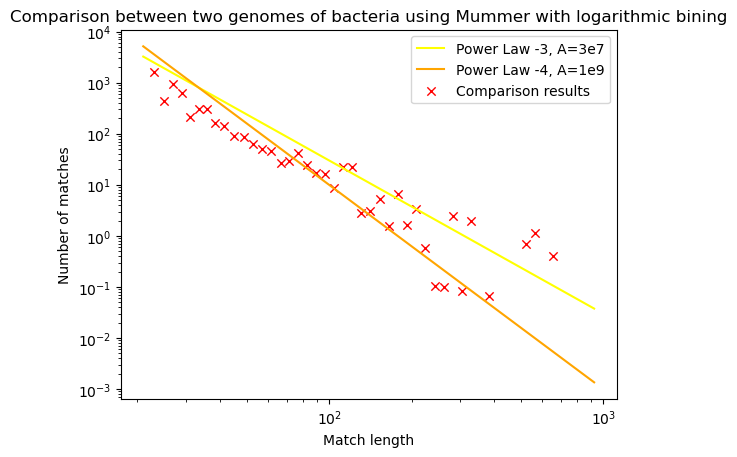

In [7]:
matches_sorted = count_occurrences(list(max_matches))
bins = floor_numbers([10**(i/30) for i in range(40, 90)])
hist, pos = [], []
index = 0

while index <= matches_sorted[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, matches_sorted)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg

pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**7/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins, Powerlaw_3, color = 'yellow', label = 'Power Law -3, A=3e7')
plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=1e9')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.title('Comparison between two genomes of bacteria using Mummer with logarithmic bining')
plt.legend(loc = 1)
plt.show()


Thanks to logarithmic bining we have been able to reduce significantly the noise with huge lengths. Now that the graph is smoother, the power-models are even more precise and it is interesting to see that each model has few points that are sticking to it.

The main issue with Mummer is that it takes too much time to deal with short matches, ie matches that are smaller than 20 nucleotides. It takes way too long to process so we have to find a solution, `Nucmer` !

### Using Nucmer

To use Nucmer, we will do approximatively the same method used with Mummer for the beginning : opening the Ubuntu terminal, running the command and storing the output (there in a new file).

In [44]:
%%capture
# define the paths to the two genome files
genome1 = "/home/antoine/fasta/NC_020307.1.fasta"
genome2 = "/home/antoine/fasta/NZ_AP017617.1.fasta"

# run nucmer to compare the genomes and save the output in a file
output_file = "output_nucmer.coords"
subprocess.run(["nucmer", "-l","20","-maxmatch","-o", "-p", "output_nucmer", genome1, genome2])
sum = 0


# parse the nucmer output file to extract the matches and their lengths
matches_n = []
with open(output_file) as f:
    lines = f.readlines()
    # I do the next step because of a weird problem regarding len(lines)
    len_lines = 0
    for element in lines :
        len_lines += 1
    for index in range(6, len_lines):
        line = lines[index]
        sum += 1
        fields = line.strip().split()
        print(fields)
        matches_n.append(int((int(fields[6]) + int(fields[7]))/2))

# compute the logarithmically binned histogram of the match lengths
matches_sorted_n = matches_n.sort()


1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "output_nucmer.ntref" of length 4634162
# construct suffix tree for sequence of length 4634162
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 46341 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /home/antoine/anaconda3/opt/mummer-3.23/mummer output_nucmer.ntref 3.87
# reading input file "/home/antoine/fasta/NZ_AP017617.1.fasta" of length 5117319
# matching query-file "/home/antoine/fasta/NZ_AP017617.1.fasta"
# against subject-file "output_nucmer.ntref"
# COMPLETETIME /home/antoine/anaconda3/opt/mummer-3.23/mummer output_nucmer.ntref 13.78
# SPACE /home/antoine/anaconda3/opt/mummer-3.23/mummer output_nucmer.ntref 9.44
4: FINISHING DATA
5: GENERATING COORDS FILE


The main difference with Nucmer is that it does not return the lengths of the match directly but zones that contains almost perfect matches.

Our technique will be to explore each zone and to extract all of the exact matches, it will considerably reduce the processing time !
To do so, we use the `show-aligns` method, still using the Ubuntu terminal.

In [9]:
show_aligns_output = subprocess.run(["show-aligns", "-r", "output_nucmer.delta", "NC_020307.1", "NZ_AP017617.1"], capture_output = True)
segments_l, segments_l_new = [], []
for line in show_aligns_output.stdout.splitlines():
    segments_l.append(line)
for line in segments_l[4:]:
    line = line.decode()
    segments_l_new.append(line)

We can now look at what the output looks like : a succesion of lines with segments comparison. What will be interesting is to use the third line of the comparison, fully constitued of empty spaces and "^". We will store each length of segments by only looking at those lines.

In [10]:
segments_l_new[:10]

['',
 '-- BEGIN alignment [ +1 8691 - 9285 | -1 2357265 - 2356672 ]',
 '',
 '',
 '8691       ttaattgcaggcataaaaaaaccagccctgagaggctggtttttaaggg',
 '2357265    ttaaatgcagatataaaaaaaccaaccgt.aaaggttggttttt.ttgg',
 '               ^     ^^            ^  ^ ^ ^   ^        ^^^  ',
 '',
 '8740       gaattttggtcggcacgagaggatttgaacctccgacccccgacacccc',
 '2357218    gatttttggtcggcacgagaggatttgaacctccgacccccgacacccc']

We will first have to separate each zone with the function written below :

In [11]:
def separate_segments(lines):
    segments = []
    segment = []
    in_segment = False
    for line in lines:
        if line.startswith("-- BEGIN "):
            in_segment = True
        elif line.startswith("--   END "):
            in_segment = False
            segments.append(segment[2:-2])
            segment = []
        elif in_segment:
            segment.append(line)
    return segments

Then we have several steps to get only the lines that are intersting, erasing the beginning of each line which is basically only empty space and to not take part into the length of the segments.

In [12]:
segments_sep = separate_segments(segments_l_new)
segments_sep.insert(0, '') 

new_list = []
for element in segments_sep:
    new_list.append(element[2::4])

new_list = new_list[1:]
lines_phrase =[]

for zone in new_list:
    phrase = ''
    for bout in zone:
        phrase += str(bout[15:])
    lines_phrase.append(phrase)
for phrase in lines_phrase[::1000]:
    print(phrase)

^     ^^            ^  ^ ^ ^   ^        ^^^                                                                                ^    ^         ^^      ^  ^   ^      ^^^  ^ ^^^                                   ^     ^     ^  ^    ^ ^  ^   ^ ^   ^  ^  ^ ^      ^ ^    ^  ^  ^^  ^^  ^  ^^ ^  ^ ^         ^  ^        ^   ^   ^  ^  ^            ^^ ^^^  ^  ^  ^  ^          ^   ^  ^^ ^ ^  ^ ^^     ^  ^  ^         ^^  ^             ^              ^   ^       ^        ^  ^  ^^                ^     ^  ^    ^     ^ ^^  ^  ^           ^  ^        ^   ^^      


Now that we are able to have only the interesting parts, we can store all the segments in a list using the following method.

In [22]:
segment_lengths = []
for phrase in lines_phrase:
    ln_seg = 0
    indice = 0
    len_phrase = 0
    for charac in phrase:
        len_phrase += 1
    while indice < len_phrase:
        if phrase[indice] == ' ':
            ln_seg += 1
            indice += 1
        else:
            if ln_seg == 0:
                indice += 1
            else:
                segment_lengths.append(ln_seg)
                indice += 1
                ln_seg = 0    
                
segment_lengths_sorted = segment_lengths.sort()
show_aligns_segments = count_occurrences(segment_lengths)

Then we can plot with the same method used before the lengths of the segments, which is now including lengths which are lower than 10 nucleotides.

We can plot the histogram (which is not really logarithmic bining because it is not divided by the length of the bin).

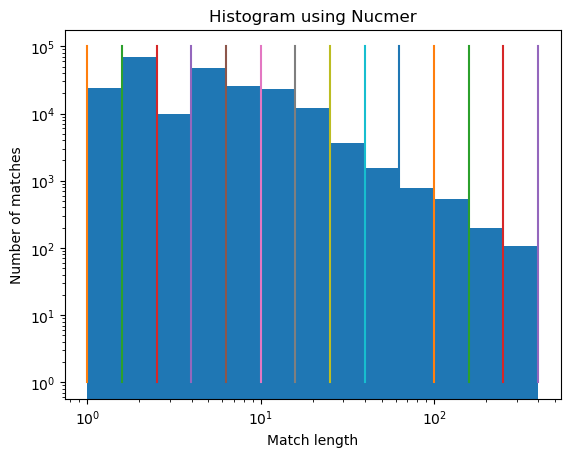

In [23]:
bins = [10**(i/5) for i in range(0, 14)]
pl.hist(segment_lengths, bins=bins)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
for bin in bins:
    plt.plot([bin,bin], [1,100000])
pl.xlabel("Match length")
pl.ylabel("Number of matches")
plt.title("Histogram using Nucmer")
pl.show()

We can plot without logarithmic bining, even though it seems that it won't be very useful because of the fact that data is not identically distributed.

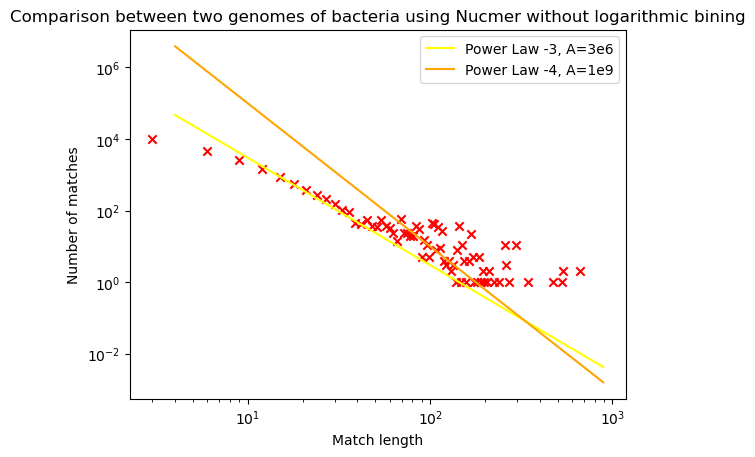

In [20]:
segment_lengths, occurrences = zip(*show_aligns_segments)
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**6/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins[6:], Powerlaw_3[6:], color = 'yellow', label = 'Power Law -3, A=3e6')
plt.plot(bins[6:], Powerlaw_4[6:], color = 'orange', label = 'Power Law -4, A=1e9')
plt.scatter(segment_lengths[2::3], occurrences[2::3], color = 'r', marker = 'x')
plt.xscale('log')
plt.title('Comparison between two genomes of bacteria using Nucmer without logarithmic bining')
plt.yscale('log')
plt.legend()
plt.show()

It is somehow interesting because we observe a kind of threshold situated at the 40th length, with a weird form then.

Then we apply our logarithmic bining to plot our comparison :

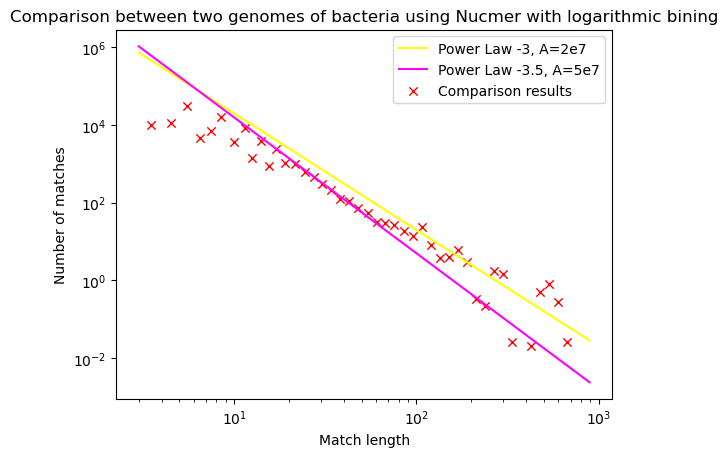

In [16]:
bins = floor_numbers([10**(i/20) for i in range(7, 60)])
hist, pos = [], []
index = 0

while index <= show_aligns_segments[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, show_aligns_segments)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg

pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [2*10**7/x**3 for x in bins]
Powerlaw_4 = [5*10**8/x**4 for x in bins]
Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'magenta', label = 'Power Law -3.5, A=5e7')
#plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.title('Comparison between two genomes of bacteria using Nucmer with logarithmic bining')
plt.legend(loc = 1)
plt.show()

There I plotted two power laws : a -3 and a -3,5. They are the more accurate ones are respect the shape of the points.

The power law is thus mainly respected between the two bacteria !

### Using blast

We can use `Blast` to align our segments but using a more efficient method. It seems that Blast do not take into account the small segments, even though I did not fix any limit. Therefore, it is not as efficient as `Nucmer` for our method.

In [43]:
%%capture
# Set the paths to the BLAST executables
makeblastdb_exe = "/home/antoine/anaconda3/envs/bio/bin/makeblastdb"
blastn_exe = "/home/antoine/anaconda3/envs/bio/bin/blastn"

# Set the paths to the input genome files
genome1_path = "/home/antoine/fasta/NC_020307.1.fasta"
genome2_path = "/home/antoine/fasta/NZ_AP017617.1.fasta"

# Set the prefix for the output files
output_prefix = "blast_output"
segment_blast = []
# Set the minimum length of matches to report
min_match_length = 1

# Create a BLAST database for each genome
makeblastdb_cmd1 = [makeblastdb_exe, "-in", genome1_path, "-dbtype", "nucl", "-out", output_prefix + "_1"]
makeblastdb_cmd2 = [makeblastdb_exe, "-in", genome2_path, "-dbtype", "nucl", "-out", output_prefix + "_2"]
call(makeblastdb_cmd1)
call(makeblastdb_cmd2)

# Run BLAST to compare the two genome sequences
blastn_cmd = [blastn_exe, "-db", output_prefix + "_1", "-query", genome2_path, "-out", output_prefix + ".out", "-outfmt", "6 qseqid sseqid pident length qstart qend sstart send"]
call(blastn_cmd)

# Read the matching segments from the BLAST output file
with open(output_prefix + ".out") as blast_output:
    for line in blast_output:
        # Parse the fields from the BLAST output
        fields = line.strip().split()
        print(fields)
        # Extract the start and end positions of the matching segment in each genome
        genome1_start = int(fields[4])
        genome1_end = int(fields[5])
        genome2_start = int(fields[6])
        genome2_end = int(fields[7])

        # Calculate the length of the matching segment
        segment_length = genome1_end - genome1_start + 1
        segment_blast.append(segment_length)
        # Check if the segment is long enough to be reported
#       if segment_length >= min_match_length:
#            # Print the matching segment details
#           print("Matching segment:")
#           print("  Genome 1: positions {}-{}".format(genome1_start, genome1_end))
#           print("  Genome 2: positions {}-{}".format(genome2_start, genome2_end))
#           print("  Length: {} nucleotides".format(segment_length))
#           print("")

# Clean up the intermediate output files
os.remove(output_prefix + "_1.nhr")
os.remove(output_prefix + "_1.nin")
os.remove(output_prefix + "_1.nsq")
os.remove(output_prefix + "_2.nhr")
os.remove(output_prefix + "_2.nin")
os.remove(output_prefix + "_2.nsq")



Building a new DB, current time: 12/28/2022 17:59:39
New DB name:   /home/antoine/blast_output_1
New DB title:  /home/antoine/fasta/NC_020307.1.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1 sequences in 0.0912662 seconds.


Building a new DB, current time: 12/28/2022 17:59:40
New DB name:   /home/antoine/blast_output_2
New DB title:  /home/antoine/fasta/NZ_AP017617.1.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1 sequences in 0.100503 seconds.


In [18]:
segment_blast_sorted = segment_blast.sort()
segment_blast_sorted = count_occurrences(list(segment_blast))

In [19]:
print(segment_blast_sorted[:10])

[[28, 1], [29, 1], [30, 2], [31, 2], [32, 1], [35, 1], [36, 7], [37, 2], [38, 3], [41, 3]]


In [28]:
bins = floor_numbers([10**(i/20) for i in range(7, 60)])
hist, pos = [], []
index = 0

while index <= segment_blast_sorted[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, segment_blast_sorted)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg

pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [2*10**7/x**3 for x in bins]
Powerlaw_4 = [5*10**8/x**4 for x in bins]
Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'magenta', label = 'Power Law -3.5, A=5e7')
#plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.title('Comparison between two genomes of bacteria using Nucmer with logarithmic bining')
plt.legend(loc = 1)
plt.show()

KeyboardInterrupt: 

Strangely, it does not work to plot the Blast output the same way that we plotted the Nucmer output. It takes too much time, maybe that this is due to the fact that Blast has a lot of lenghts represented by a single segment while Nucmer tends to regroup the size.